In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits import mplot3d

In [27]:
np.random.seed(1234)
tf.random.set_seed(1234)

In [28]:
def Lorenz(t,inp):
  x = inp[0]
  y = inp[1]
  z = inp[2]

  rho   = 28.
  sigma = 10.
  beta  = 8./3.

  dxdt = sigma*(y-x)
  dydt = x*(rho-z) - y
  dzdt = x*y - beta*z

  return [dxdt, dydt, dzdt]

In [29]:
sol = solve_ivp(Lorenz, [0,50], [-8.0, 7.0, 27.0], t_eval = np.linspace(0,25,2501))

In [30]:
lorenz_data = np.zeros((30,3,2501))
for i in range(30):
  x0 = np.random.random()*20 - 10
  y0 = np.random.random()*30 - 15
  z0 = np.random.random()*40
  sol = solve_ivp(Lorenz, [0,25], [x0, y0, z0], t_eval = np.linspace(0,25,2501))
  lorenz_data[i,:,:] = sol['y']

In [31]:
lorenz_data.shape

(30, 3, 2501)

In [32]:
inputs = lorenz_data[:25,:,:] 

window_size = 2
num_windows = 2501//window_size
remainder = (2501 - 1)%window_size

def preprocess(A):
    if remainder!=0:  
      Q_truncated = Q[:,:-remainder]
    else:
      Q_truncated = Q

    Q_inp = Q_truncated[:,:-1]
    Q_inp = Q_inp.reshape((-1, window_size))

    Q_tru = Q_truncated[:,1:]
    Q_tru = Q_tru.reshape((-1, window_size))

    return Q_inp, Q_tru

PQ_tru = []
PQ_inp = []

for i in range(3):

    Q = inputs[:,i,:]
    Q_inp,Q_true = preprocess(Q)
    PQ_inp.append(Q_inp)
    PQ_tru.append(Q_true)
    print(Q_inp.shape, Q_true.shape)

PQ_tru = np.stack((PQ_tru[0],PQ_tru[1],PQ_tru[2]),axis = -1)
PQ_inp = np.stack((PQ_inp[0],PQ_inp[1],PQ_inp[2]),axis = -1)
print(PQ_tru.shape)
print(PQ_inp.shape)

(31250, 2) (31250, 2)
(31250, 2) (31250, 2)
(31250, 2) (31250, 2)
(31250, 2, 3)
(31250, 2, 3)


In [14]:
class LSTM_model(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.lstm = tf.keras.layers.LSTM(18, return_sequences=True)
    self.dense = tf.keras.layers.Dense(3)

  def call(self, inputs):
    x = self.lstm(inputs)
    output = self.dense(x)
    return output

  def loss(self, predictions, truth):
    return tf.reduce_mean((predictions-truth)**2)

In [15]:
model = LSTM_model()
input = tf.random.normal([32,10,3]) #batch_sz, window_sz, num_features
output = model(input)

In [16]:
model.summary()
print(output.shape)

Model: "lstm_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               multiple                  1584      
                                                                 
 dense_2 (Dense)             multiple                  57        
                                                                 
Total params: 1,641
Trainable params: 1,641
Non-trainable params: 0
_________________________________________________________________
(32, 10, 3)


In [24]:
model = LSTM_model()


optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

num_epochs = 1000
batch_size = 512
num_batches = PQ_inp.shape[0]//batch_size
loss_list = []
for i in range(num_epochs):
  batch_loss = []   
  for j in range(num_batches):
    start = j*batch_size
    end   = (j+1)*batch_size
    with tf.GradientTape() as tape:
      y_pred = model.call(PQ_inp[start:end,:,:])
      loss = model.loss(y_pred, PQ_tru[start:end,:,:])
    
    gradients = tape.gradient(loss, model.trainable_variables)
    #print(gradients)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    batch_loss.append(loss)
  loss_list.append(sum(batch_loss)/len(batch_loss))
  if i % 50 == 0:
    print(f"Loss on training set after {i} training steps: {sum(batch_loss)/len(batch_loss)}")

Loss on training set after 0 training steps: 272.0174865722656
Loss on training set after 50 training steps: 148.92945861816406
Loss on training set after 100 training steps: 100.00848388671875
Loss on training set after 150 training steps: 67.20706176757812
Loss on training set after 200 training steps: 44.458648681640625
Loss on training set after 250 training steps: 29.2408447265625
Loss on training set after 300 training steps: 18.685274124145508
Loss on training set after 350 training steps: 11.743701934814453
Loss on training set after 400 training steps: 7.091598987579346
Loss on training set after 450 training steps: 4.214155197143555
Loss on training set after 500 training steps: 2.517496347427368
Loss on training set after 550 training steps: 1.5083521604537964
Loss on training set after 600 training steps: 0.9292498826980591
Loss on training set after 650 training steps: 0.5723536610603333
Loss on training set after 700 training steps: 0.35045701265335083
Loss on training se

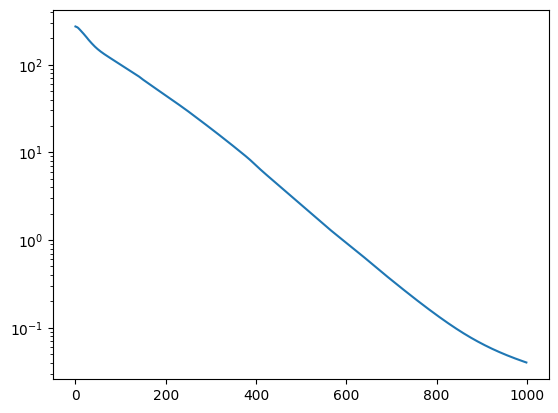

In [25]:
plt.semilogy(loss_list)

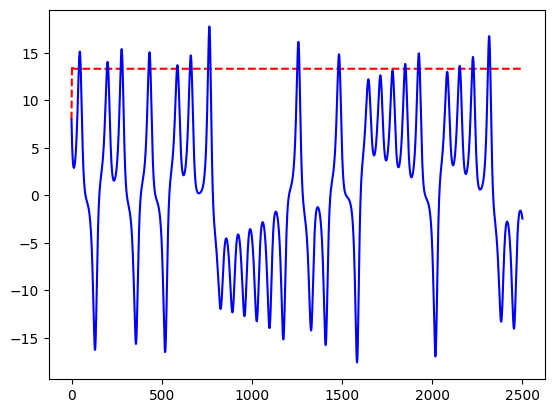

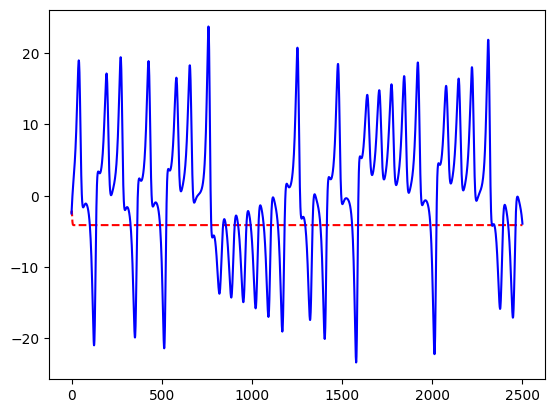

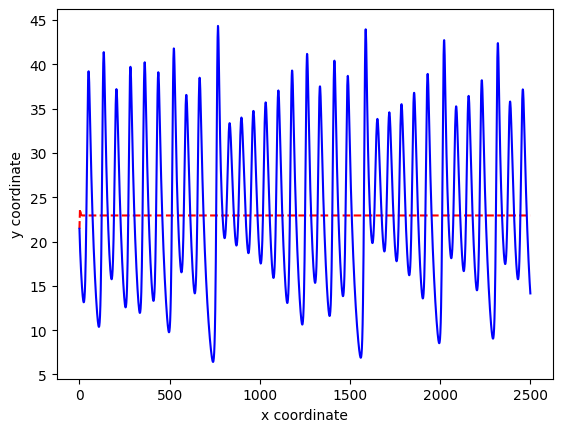

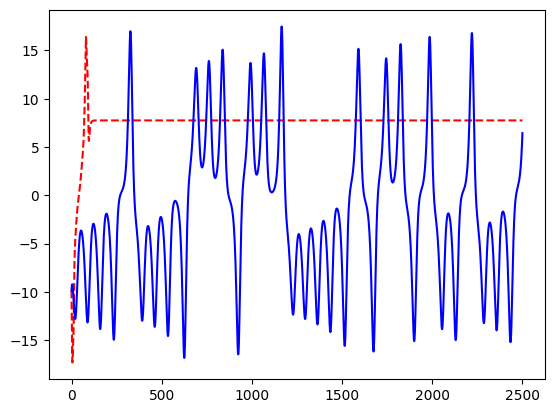

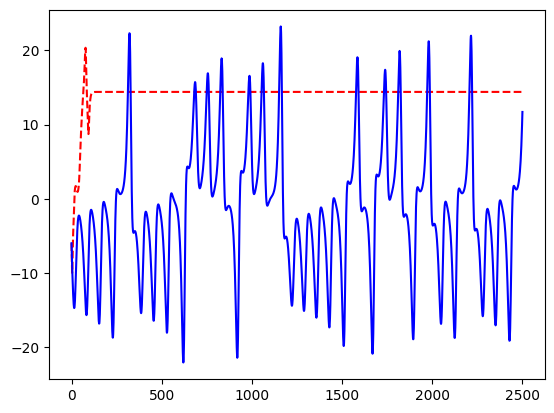

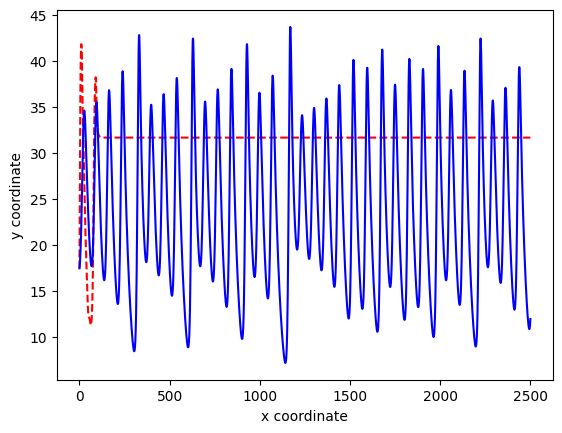

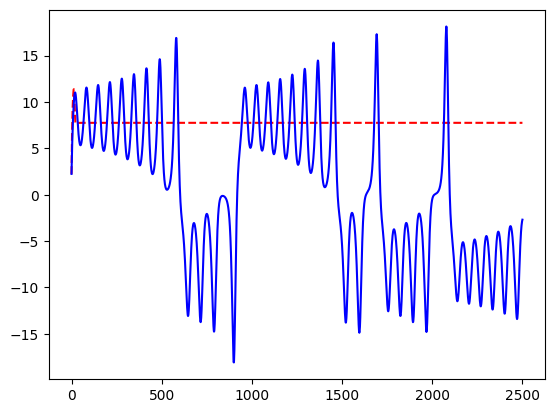

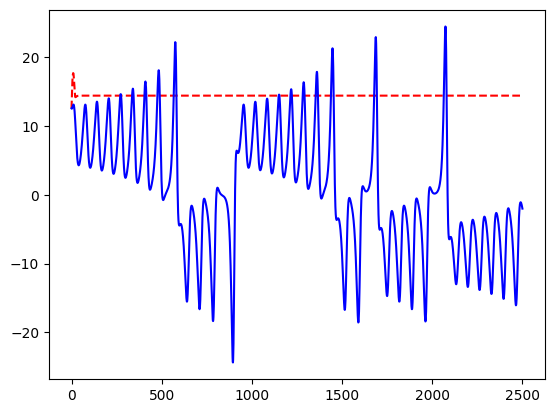

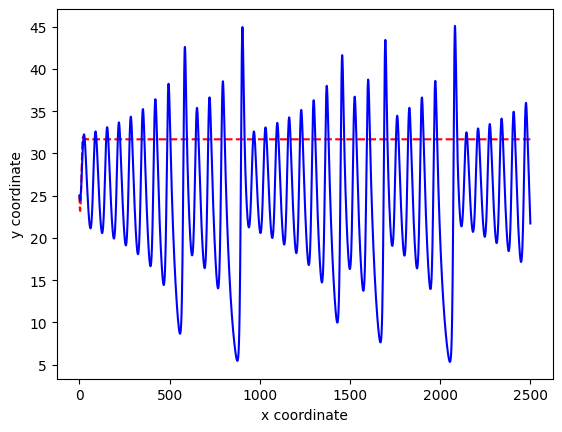

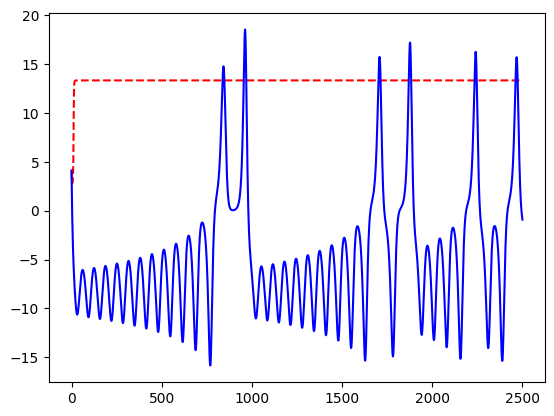

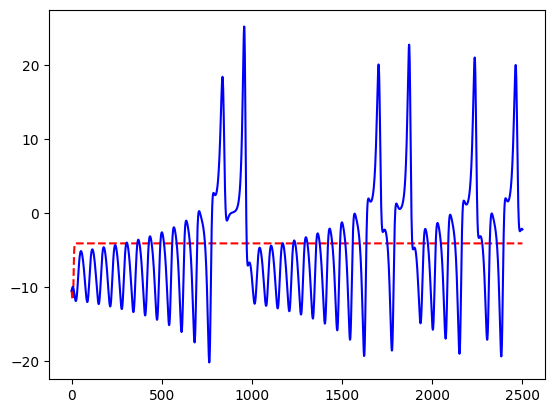

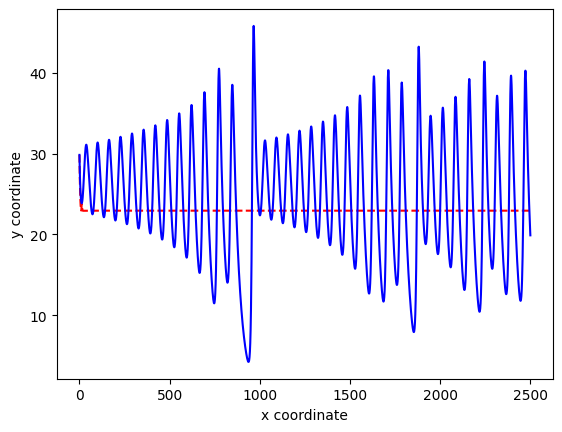

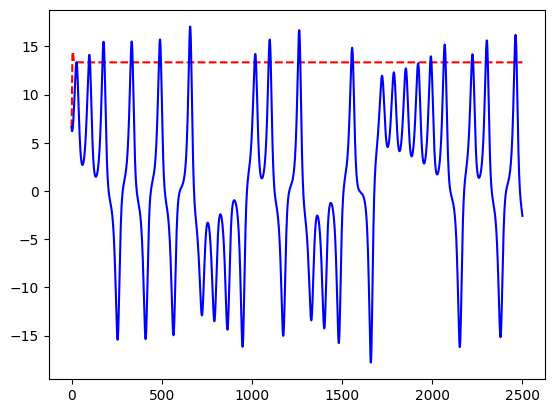

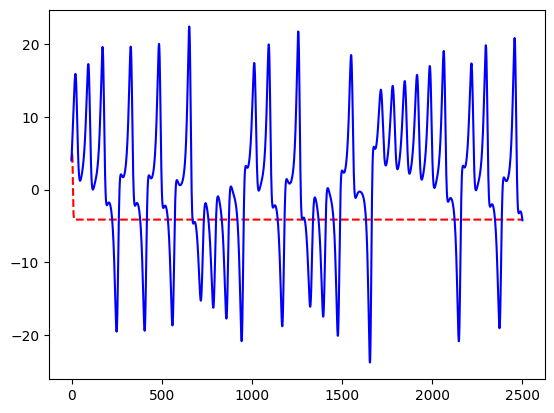

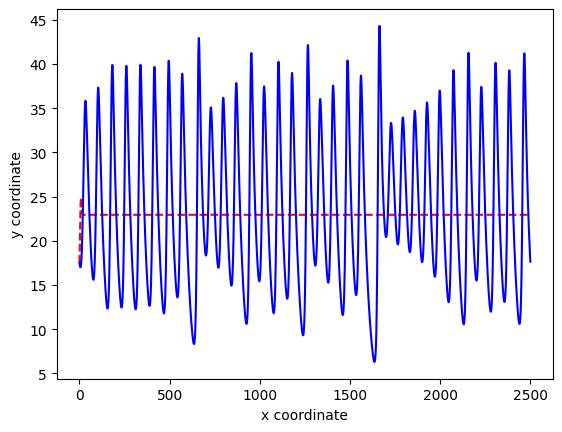

[0.7217051258081776, 0.8950962093421714, 0.7956131581221684, 0.7794459189513915, 0.717493832754579]
0.7818708489956976


In [34]:
test_err_sum_3b = []
for i in range(25,30):

    test_inp =  lorenz_data[i,:,0]

    main_list = np.array(lorenz_data[i,:,0])
    #x0 = Q[27,0]
    #y0 = P[27,0]
    for j in range(2500):
        inp = tf.convert_to_tensor(np.array([[test_inp]]))
        out = model.call(inp).numpy()
        test_inp = out[0,0,:]
        main_list = np.vstack((main_list,test_inp))

    main_list = main_list.T
    plt.plot(main_list[0,:],'--r')
    plt.plot(lorenz_data[i,0,:],'b')

    plt.figure()
    plt.plot(main_list[1,:],'--r')
    plt.plot(lorenz_data[i,1,:],'b')

    plt.figure()
    plt.plot(main_list[2,:],'--r')
    plt.plot(lorenz_data[i,2,:],'b')

    plt.xlabel('x coordinate')
    plt.ylabel('y coordinate')
    plt.show()
    
    sum_square = []
    sum_square_or = []

    for z in range(3):
        q = main_list[z,:]
        q_true = lorenz_data[i,z,:]
        sum_square.append(np.sum((q- q_true)**2))
        sum_square_or.append(np.sum(q_true**2))
        #print(q_true**2)
    test_err_sum_3b.append(np.sqrt(np.sum(np.array(sum_square)))/np.sqrt(np.sum(np.array(sum_square_or))))
print(test_err_sum_3b)
print(np.mean(test_err_sum_3b))